In [1]:
import os
import struct

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

import nibabel as nib

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

import cv2
from Pyron.utils.image import Image

from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM


N_SLIDES  = 176
N_WEIGHTS = 2
N_CASES   = 10
N_ANGLES  = 20

TOT_FILE  = N_SLIDES * N_WEIGHTS * N_CASES * N_ANGLES

def shift(img, ox, oy):
  
  non = lambda s: s if s<0 else None
  mom = lambda s: max(0,s)

  shifted = np.zeros_like(img) + img[0,0]
  shifted[mom(oy):non(oy), mom(ox):non(ox)] = img[mom(-oy):non(-oy), mom(-ox):non(-ox)]

  return shifted
  
def load_dataset():

  filename = os.path.join('~', 'data_NAMIC', 'psnr_ssim_rotate_orig.csv')

  df = pd.read_csv(filename)

  assert len(df) == TOT_FILE

  weights = df['weight'].unique()
  scales  = df['scale'].unique()

  dataframe_list = []
  for w in weights:
    for s in scales:
      w_cond = df['weight'] == w
      s_cond = df['scale'] == s

      dataframe_list.append(df[w_cond & s_cond])

  # order : [t2, 2] [t2, 4] [t1, 2] [t1, 4]
  return [d.reset_index(drop=True) for d in dataframe_list]

def build_filename(case, weight, scale, slide, angle):
  
  root = os.path.join(os.path.expanduser('~'), 'data_NAMIC')
  orig = os.path.join(root, 'orig', weight, f'{case}_{weight}.nii') 

  sr = os.path.join(root, weight, f'{case}_{weight}_{scale}lr_bc_gauss_sr', f'sample_{slide:03}_{angle:03}.bin')
  bc = os.path.join(root, weight, f'{case}_{weight}_{scale}lr_bc_gauss_bc', f'sample_{slide:03}.bin')

  return orig, sr, bc

def load_bin(filename, dtype):

  with open(filename, 'rb') as f:

    h, w, c = struct.unpack('iii', f.read(12))
    out = np.fromfile(f, dtype=dtype, offset=0).reshape(h, w, c)
  
  return out

def rescale(im):
  return (im - im.min()) * (1. / (im.max() - im.min()))

def rescale_by_channel(im):

  M = im.max(axis=(0, 1))
  m = im.min(axis=(0, 1))

  return (im - m) * (1. / (M - m))

def load_images(case, weight, scale, slide, angle):
  
  origName, srName, bcName = build_filename(case, weight, scale, slide, angle)

  orig = nib.load(origName).get_fdata()
  orig = rescale(orig)[:,:,slide]
  orig = cv2.rotate(orig, cv2.ROTATE_90_COUNTERCLOCKWISE)
#   orig = cv2.flip(orig, flipCode=1)

  bc = load_bin(bcName, 'float64')[:,:,0]  
  bc = rescale(bc)
  bc = cv2.rotate(bc, cv2.ROTATE_90_CLOCKWISE)
  
  sr = load_bin(srName, 'float32')
  sr = Image.from_numpy_matrix(sr).rotate(-angle).data
  sr = cv2.flip(sr, flipCode=1)
  sr = rescale_by_channel(sr)
  
  return orig, sr, bc

def name_switch(df):
  
  if df is df_x2_t2:
    return 'model edsrx2 in t2'

  elif df is df_x2_t1:
    return 'model edsrx2 in t1'

  elif df is df_x4_t2:
    return 'model wdsrx4 in t2'

  elif df is df_x4_t1:
    return 'model wdsrx4 in t1'

  else:
    raise ValueError('dt is wrong')

df_x2_t2, df_x4_t2, df_x2_t1, df_x4_t1 = load_dataset()

assert df_x2_t2['weight'].unique() == ['t2']
assert df_x4_t2['weight'].unique() == ['t2']
assert df_x2_t1['weight'].unique() == ['t1']
assert df_x4_t1['weight'].unique() == ['t1']
assert df_x2_t1['scale'].unique() == [2]
assert df_x2_t2['scale'].unique() == [2]
assert df_x4_t1['scale'].unique() == [4]
assert df_x4_t2['scale'].unique() == [4]

In [30]:
df_x2_t1

,angle (deg),case,psnr_bc,psnr_sr_1,psnr_sr_2,psnr_sr_3,scale,shape,slide,ssim_bc,ssim_sr_1,ssim_sr_2,ssim_sr_3,weight
0,0.0,case01011,20.532493,17.034406,19.273190,22.359432,2.0,"(256, 256)",0.0,0.533674,0.088982,0.131337,0.352519,t1
1,18.0,case01011,20.532493,18.480939,14.530746,14.822307,2.0,"(256, 256)",0.0,0.533674,0.209049,0.063193,0.066173,t1
2,36.0,case01011,20.532493,20.277536,18.213820,19.235840,2.0,"(256, 256)",0.0,0.533674,0.285920,0.125589,0.181068,t1
3,54.0,case01011,20.532493,14.473077,17.961589,16.180184,2.0,"(256, 256)",0.0,0.533674,0.062973,0.124579,0.082908,t1
4,72.0,case01011,20.532493,18.157257,14.885553,17.109074,2.0,"(256, 256)",0.0,0.533674,0.148066,0.065823,0.103154,t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,270.0,case01015,16.934864,12.696808,15.417647,12.665363,2.0,"(256, 256)",175.0,0.182618,0.054974,0.095041,0.055294,t1
17596,288.0,case01015,16.934864,9.584340,14.464974,10.390205,2.0,"(256, 256)",175.0,0.182618,0.038573,0.117059,0.042943,t1
17597,306.0,case01015,16.934864,11.507746,12.131272,10.791579,2.0,"(256, 256)",175.0,0.182618,0.049040,0.053893,0.044261,t1
17598,324.0,case01015,16.934864,14.562290,11.130930,12.596503,2.0,"(256, 256)",175.0,0.182618,0.107773,0.046089,0.058308,t1


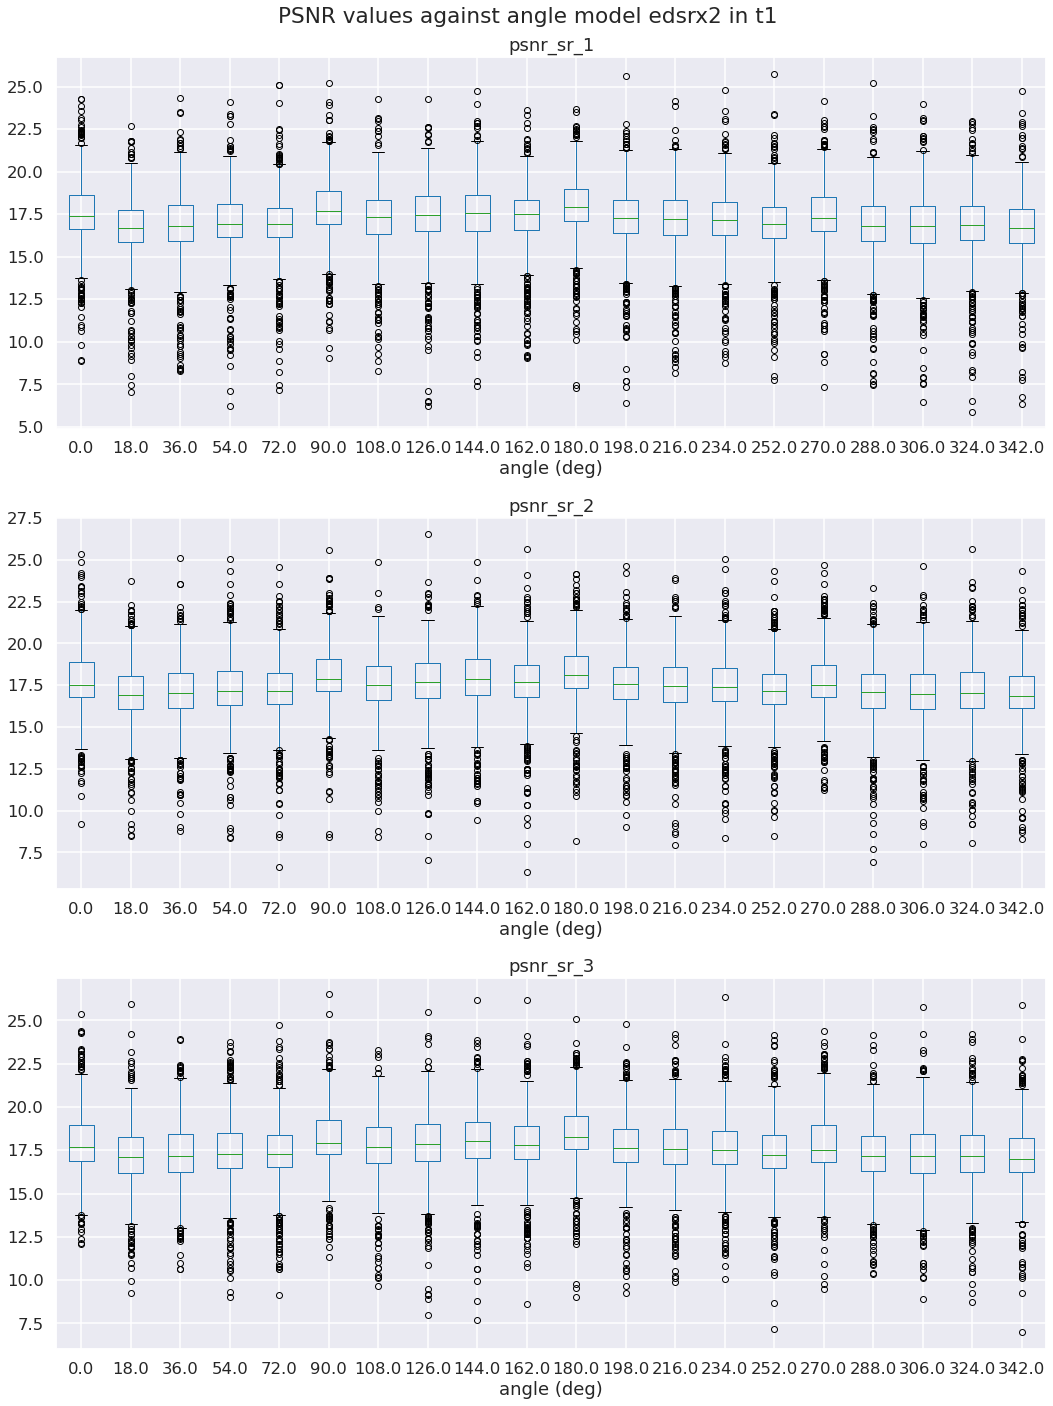

In [107]:
# start from simply x2_t1 for example

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='psnr_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle(f'PSNR values against angle {name}')

plt.tight_layout()
plt.show()

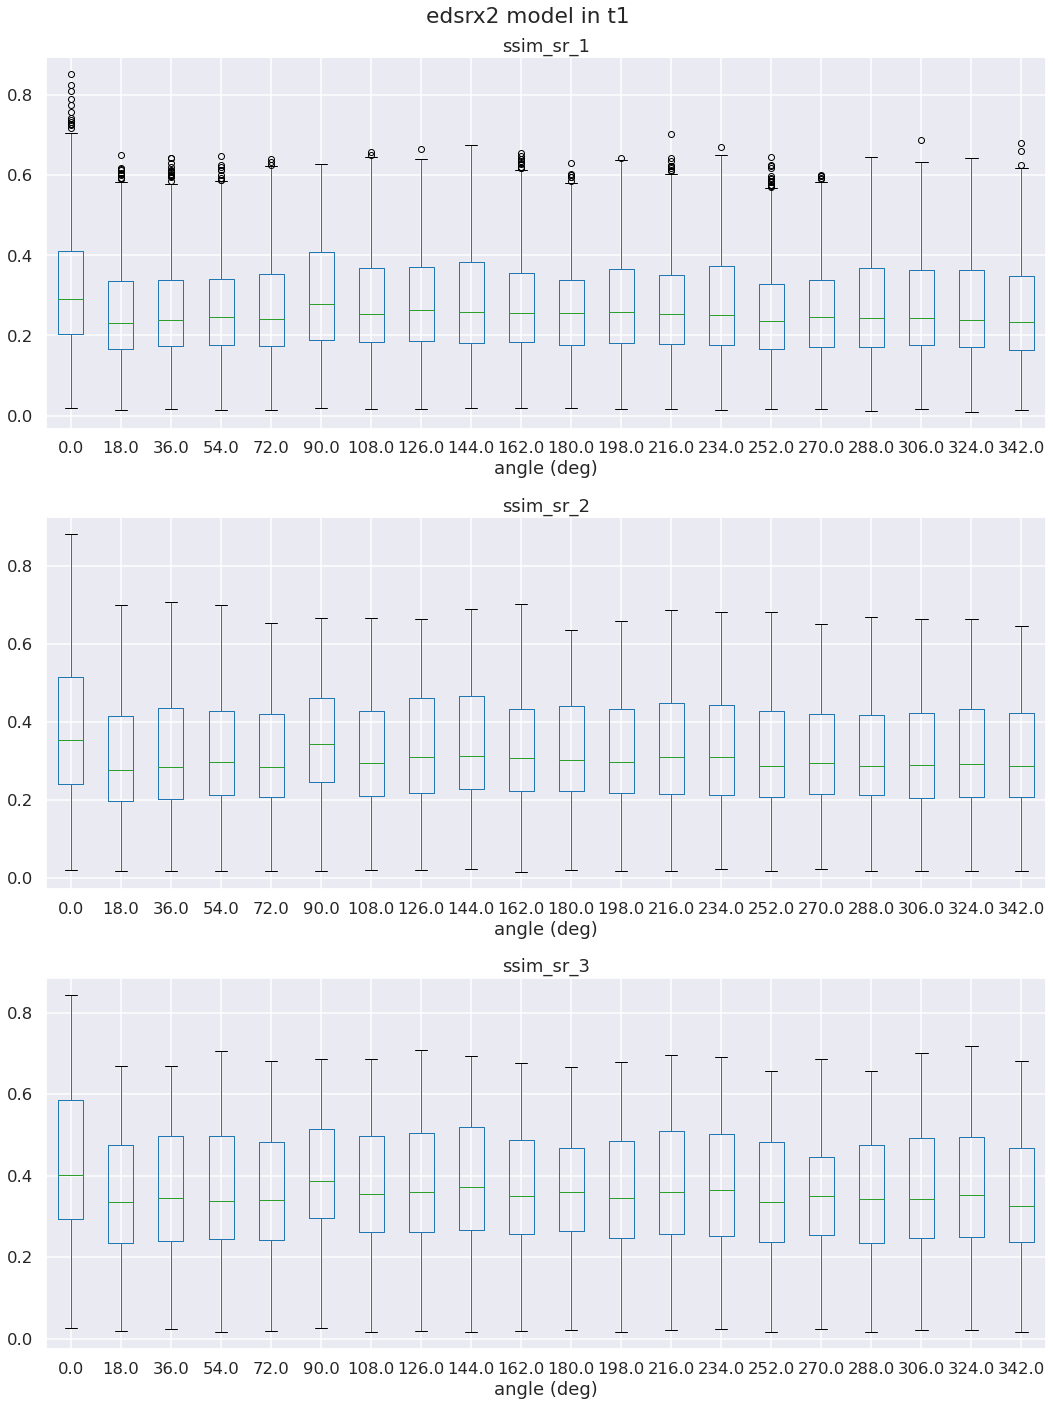

In [58]:
# ssim  boxplotting for edsr and 

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='ssim_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle('edsrx2 model in t1')
  
plt.tight_layout()
plt.show()

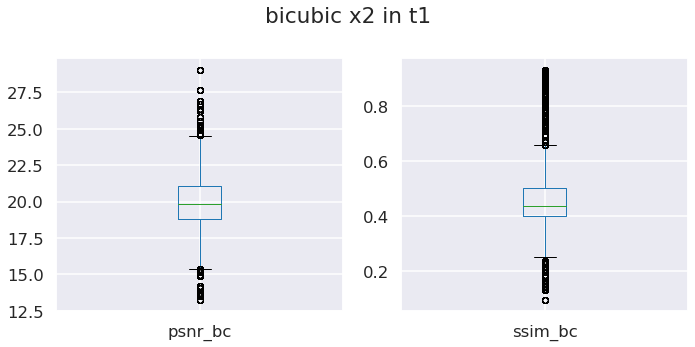

In [115]:
# bc boxplot

dt = df_x2_t1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

dt.boxplot(ax=ax1, column='psnr_bc')
dt.boxplot(ax=ax2, column='ssim_bc')

fig.suptitle('bicubic x2 in t1')
  
plt.tight_layout()
plt.show()

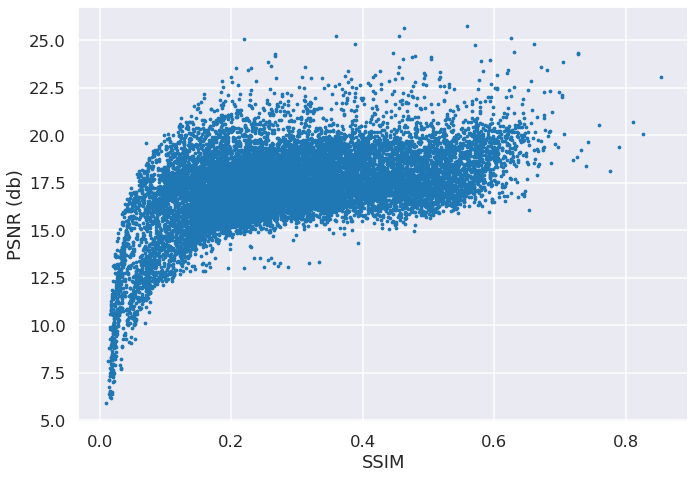

In [35]:
# graph psnr-ssim. The other cases are very different

dt = df_x2_t1
name = name_switch(dt)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

dt.plot.scatter(ax=ax, x='ssim_sr_1', y='psnr_sr_1', marker='.')
ax.set_xlabel('SSIM')
ax.set_ylabel('PSNR (db)')

plt.tight_layout()
plt.show()

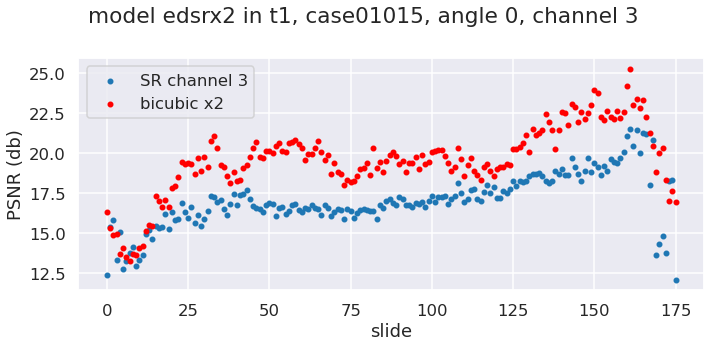

In [33]:
# scatter for value of psnr separated per scale and angle

sns.set_style('darkgrid')

dt = df_x2_t1
name = name_switch(dt)

case = 'case01015'
ang  = 0
chan = 3

angle_cond = dt['angle (deg)'] == ang
case_cond  = dt['case'] == case

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y=f'psnr_sr_{chan}', ax=ax,    label=f'SR channel {chan}')
dt.plot.scatter(x='slide', y='psnr_bc', ax=ax, color='r', label=f'bicubic {name.split(" ")[1].split("r")[1]}')

ax.set_ylabel('PSNR (db)')
ax.legend()

fig.suptitle(f'{name}, {case}, angle {ang}, channel {chan}')
plt.tight_layout()
plt.show()

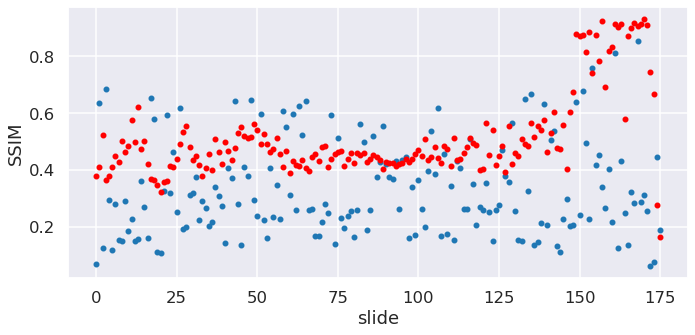

In [24]:
# scatter for value of ssim separated per case and angle

sns.set_style('darkgrid')

dt = df_x2_t1

angle_cond = dt['angle (deg)'] == 0
case_cond  = dt['case'] == 'case01028'

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y='ssim_sr_1', ax=ax)
dt.plot.scatter(x='slide', y='ssim_bc', ax=ax, color='r')

ax.set_ylabel('SSIM')

plt.tight_layout()
plt.show()

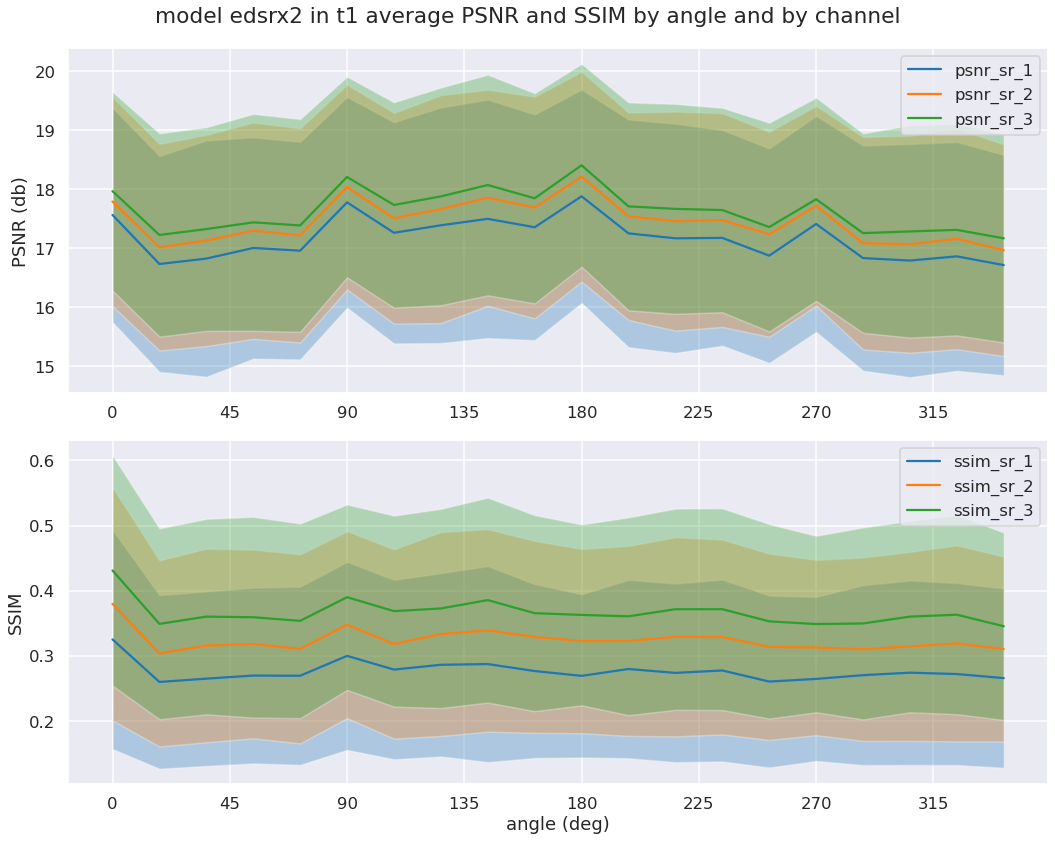

In [26]:
# plot of mean psnr and ssim as function of angle

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by angle and by channel')
plt.tight_layout()
plt.show()

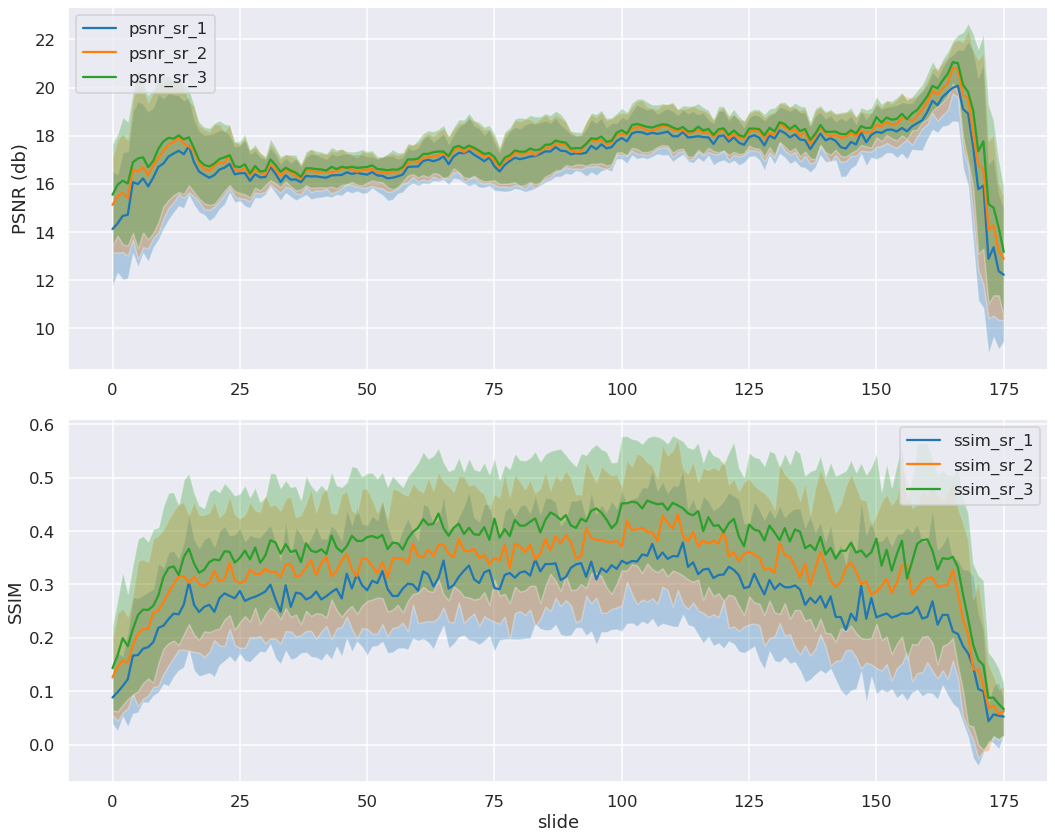

In [79]:
# same as above for angles

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()

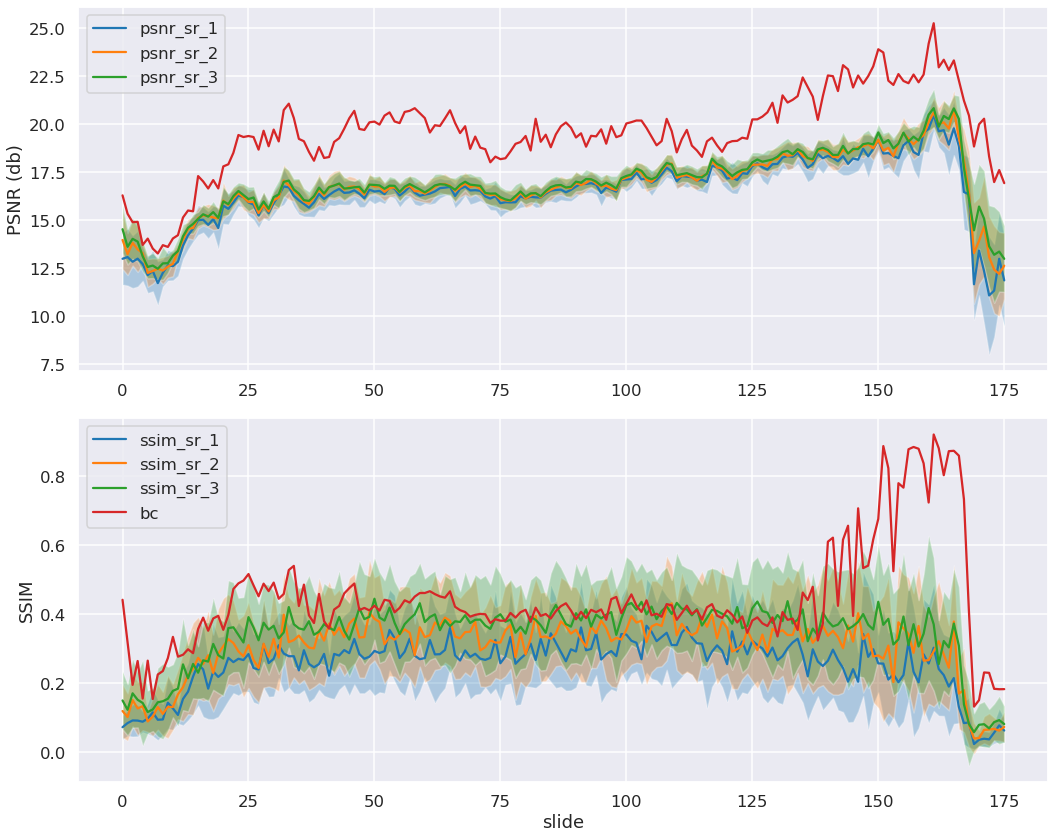

In [111]:
# analysis on case01015, image available for t1 for bc, srx2 and srx4

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

## Boxplot essentially the same

## Plot grouped by slide
byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

ax1.plot(x, avg['psnr_bc'], label='bc')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.plot(x, avg['ssim_bc'], label='bc')
ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()


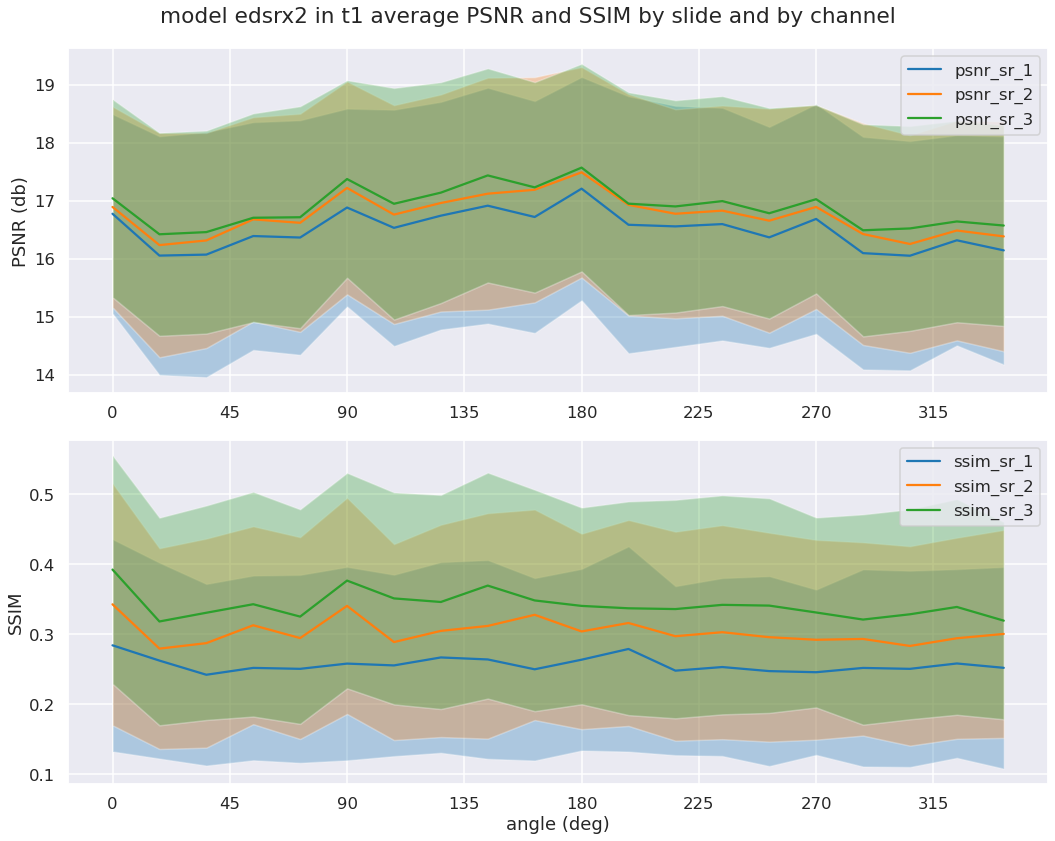

In [110]:
# same as above with 

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by slide and by channel')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

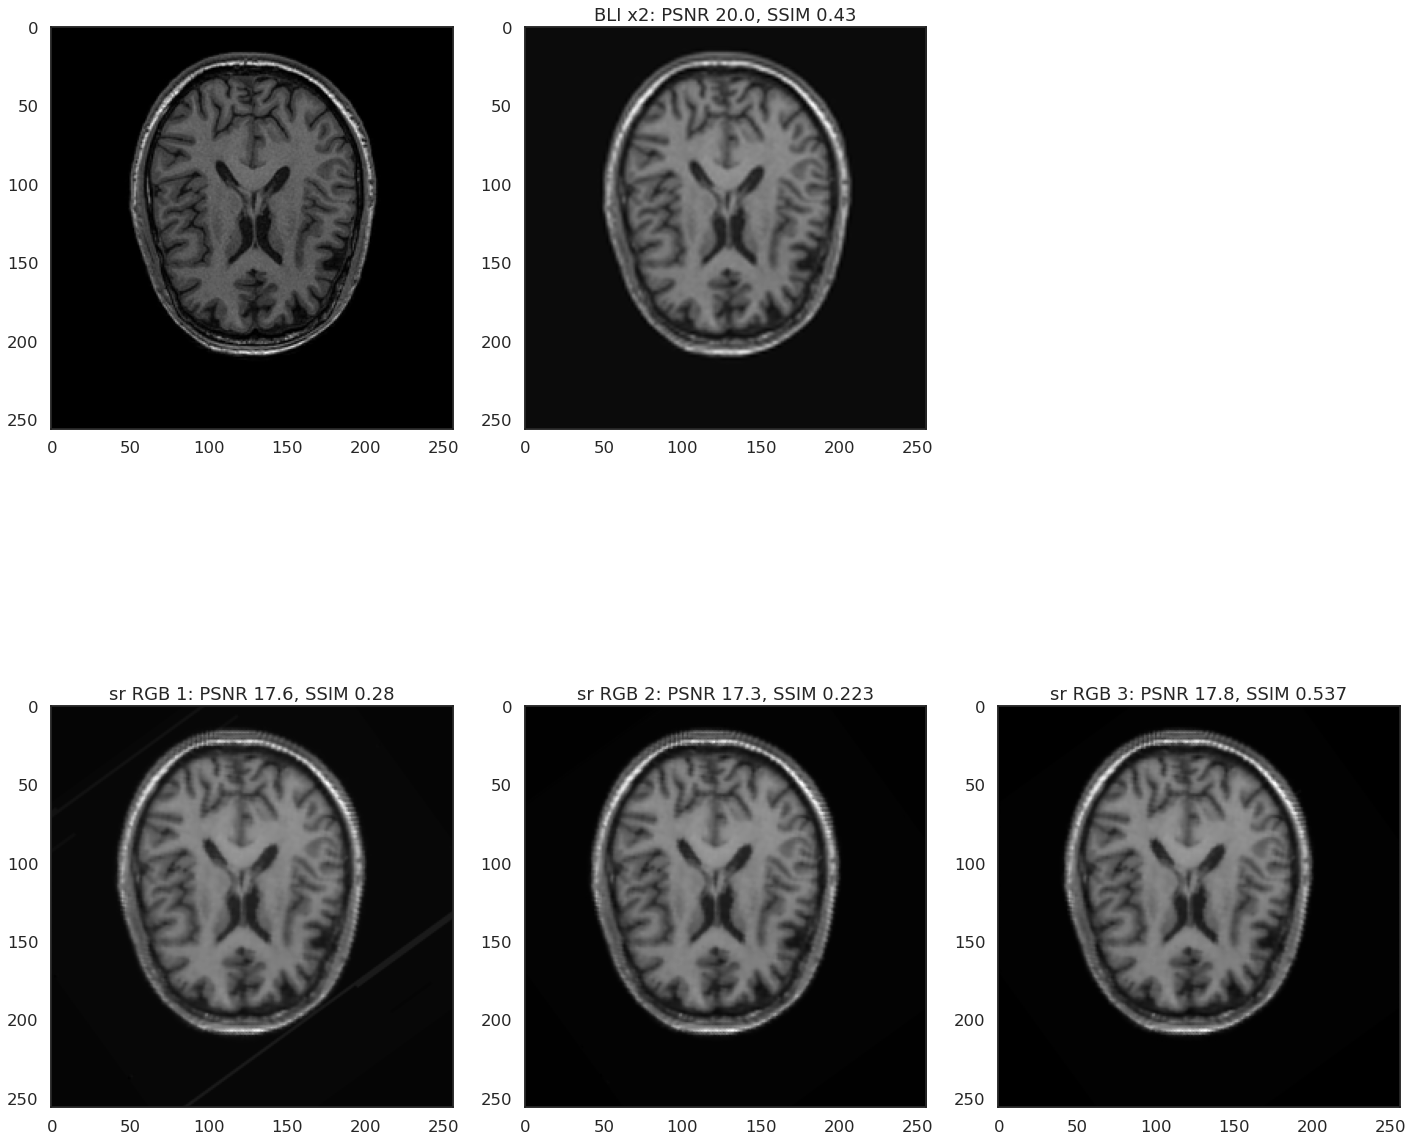

0.5223949523116449 19.953080242477537
0.7717214925584239 20.165534520990605
0.838108568810982 20.29820523515676


In [219]:
# show some images for case01015, the range is approximately from 0 to 170

sns.set_style('white')
sns.set_context('talk')
plt.set_cmap('gray')

dt = df_x2_t1

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 36
scale  = 2

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, sr, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, (row1, row2) = plt.subplots(2, 3, figsize=(20, 20))

ax1, ax2, ax6 = row1

ax1.imshow(orig)
ax2.imshow(bc)
ssim = dt['ssim_bc'].values[0]
psnr = dt['psnr_bc'].values[0]
ax2.set_title(f'BLI x{scale}: PSNR {psnr:.3}, SSIM {ssim:.3}')

for i, ax in enumerate(row2):
  ssim = dt[f'ssim_sr_{i+1}'].values[0]
  psnr = dt[f'psnr_sr_{i+1}'].values[0]
  ax.imshow(sr[:,:,i])
  ax.set_title(f'sr RGB {i+1}: PSNR {psnr:.3}, SSIM {ssim:.3}')

ax6.remove()
plt.tight_layout()
plt.show();

for i in range(3):
  print(SSIM(orig, shift(sr[:,:,i], ox=scale*4, oy=0)), PSNR(orig, shift(sr[:,:,i], ox=scale*4, oy=0)))

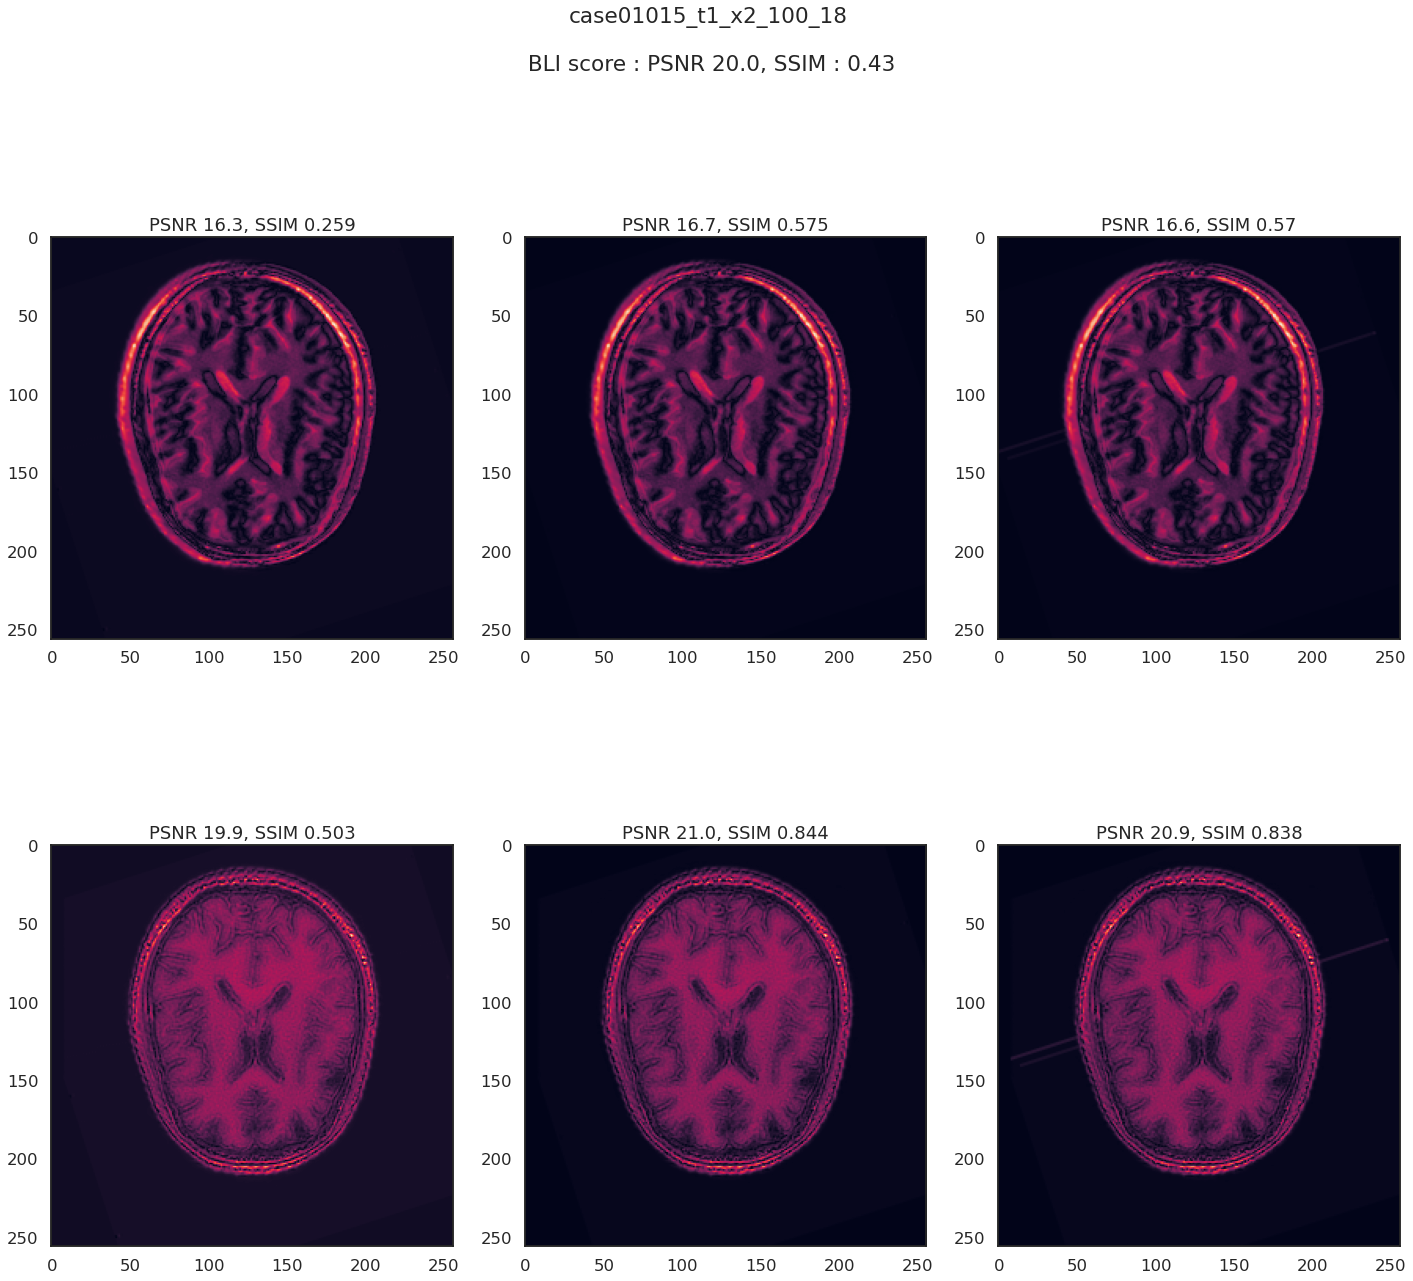

In [236]:
# absolute diff by channel orig - sr 

sns.set_style('white')
sns.set_context('talk')
# plt.set_cmap('')

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 18
scale  = 2

if scale == 2:
  dt = df_x2_t1
elif scale == 4:
  dt = df_x4_t1

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, sr, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, (row1, row2) = plt.subplots(2, 3, figsize=(20, 20))

bc_psnr = PSNR(orig, bc)
bc_ssim = SSIM(orig, bc)

PSRNs = [PSNR(orig, sr[:,:,i]) for i in range(3)]
SSIMs = [SSIM(orig, sr[:,:,i]) for i in range(3)]

for i, ax in enumerate(row1):
  psnr = PSRNs[i]
  ssim = SSIMs[i]
  ax.imshow(np.abs(orig - sr[:,:,i]))
  ax.set_title(f'PSNR {psnr:.3}, SSIM {ssim:.3}')

PSRNs = [PSNR(orig, shift(sr[:,:,i], ox=scale*4, oy=0)) for i in range(3)]
SSIMs = [SSIM(orig, shift(sr[:,:,i], ox=scale*4, oy=0)) for i in range(3)]
  
for i, ax in enumerate(row2):
  psnr = PSRNs[i]
  ssim = SSIMs[i]
  ax.imshow(np.abs(orig - shift(sr[:,:,i], ox=scale*4,oy=0)))
  ax.set_title(f'PSNR {psnr:.3}, SSIM {ssim:.3}')
  
title = f'{case}_{weight}_x{scale}_{slide}_{angle}'
fig.suptitle(title + f'\n\n BLI score : PSNR {bc_psnr:.3}, SSIM : {bc_ssim:.3}')
plt.tight_layout();
plt.savefig('../images/' + title)

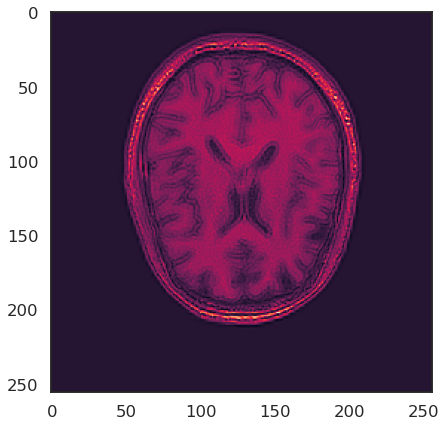

In [206]:
# absolute diff by channel orig - bc

sns.set_style('white')
sns.set_context('talk')
# plt.set_cmap('')

dt = df_x2_t1

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 0
scale  = 2

if scale == 2:
  dt = df_x2_t1
elif scale == 4:
  dt = df_x4_t1

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, _, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.imshow(np.abs(orig - bc))

plt.show();

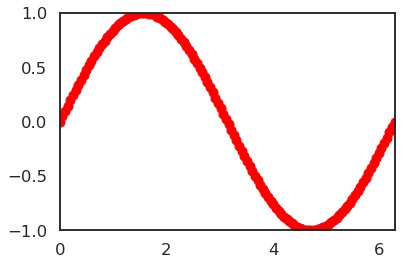

In [213]:
# animation fixed slide, move angle.

sns.set_style('white')
sns.set_context('talk')
# plt.set_cmap('')

case   = 'case01015'
weight = 't1'

angle  = np.arange(0, 360, 18)
slide  = 100
scale  = 2

fig, row = plt.subplots(1, 3, )

def init():
  
  for i, ax in enumerate(row):
    ax.imshow()
  
  return 

def update(frame):
  
  for i, ax in enumerate(row):
    ax.imshow(sr[:,:,i])
  
  return ln,

anim = FuncAnimation(fig, update, frames=angle,
                    init_func=init, blit=True)



anim.save('../images/byangle.gif')

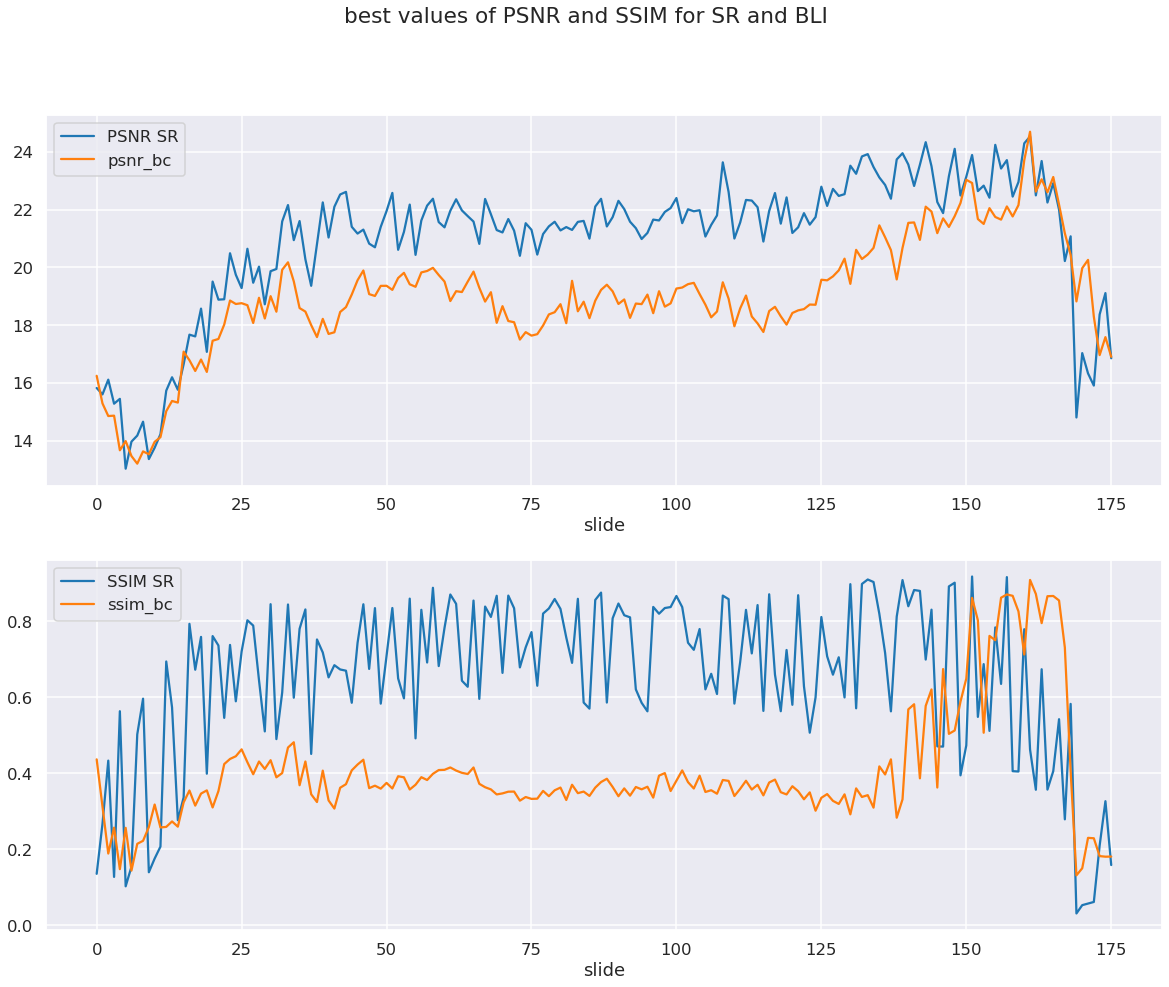

In [41]:
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angle = 0 
scale = 2 
# slide = 100

angle_mask = shift_df['angle (deg)'] == angle
scale_mask = shift_df['scale'] == scale

shift_df = shift_df[angle_mask & scale_mask]

psnr_best_values = []
ssim_best_values = []
for i in range(176):
  
  slide_mask = shift_df['slide'] == i 
  
  best_psnr = shift_df[slide_mask][[f'psnr_sr_{i+1}' for i in range(3)]].values.max()
  best_ssim = shift_df[slide_mask][[f'ssim_sr_{i+1}' for i in range(3)]].values.max()

  psnr_best_values.append(best_psnr)
  ssim_best_values.append(best_ssim)
    
  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

ax1.plot(shift_df['slide'], psnr_best_values, label='PSNR SR')
ax2.plot(shift_df['slide'], ssim_best_values, label='SSIM SR') 
  
shift_df.plot(ax=ax1, y='psnr_bc', x='slide')
shift_df.plot(ax=ax2, y='ssim_bc', x='slide')

ax1.legend()
ax2.legend()

fig.suptitle('best values of PSNR and SSIM for SR and BLI')

# plt.tight_layout()
plt.show();

In [15]:
# same per angle

In [ ]:
# animation with diff orig - sr 
# animation with diff orig - bc
# mostrare una immagine nel range 0-10
# mostrare immagini nel range 20-150
# animation with varying angle per slide == 100